# Tutorial 1: 10X Visium

In [8]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
#from utils import clustering
import multiprocessing as mp

In [9]:
from DeepST import DeepST

In [10]:
# Run device
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# the location of R 
os.environ['R_HOME'] = '/scbio4/tools/R/R-4.0.3_openblas/R-4.0.3'

In [27]:
# the number of clusters
n_clusters = 7

In [36]:
dataset = '151507'

In [37]:
# read data
file_fold = '/home/yahui/Yahui/Projects/data/' + str(dataset)
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()

/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [38]:
# define and run model
model = DeepST.DeepST(adata, device=device)
adata = model.train_DeepST()

 |                                | 15/600|Loss:12.7862939835|Time:0.1940

Begin to train ST data.


 |################################| 600/600|Loss:8.4684629440|Time:8.0216


Training finished for spot representation learning!


In [39]:
adata

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'emb', 'emb_reg'

In [40]:
# define radius to limit the number of neighbors during refinement
radius = 50

# clustering
from DeepST.utils import clustering
clustering(adata, n_clusters, radius=radius, refinement=True) # if 'refinement' is set as 'True', the clustering result would be improved.

fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


In [41]:
# add ground_truth
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values

In [42]:
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])] 
        
# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI
    
print('Dataset:', dataset)
print('ARI:', ARI)

/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Dataset: 151507
ARI: 0.5688551654462641


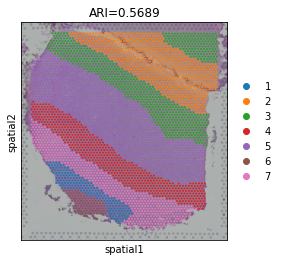

In [43]:
# plotting spatial clustering result
sc.pl.spatial(adata, img_key="hires", color=["domain"], title=['ARI=%.4f'%ARI], show=True)